# Milestone 2 Phase 2

## Introduction

Nama  : Fitri Octaviani

Batch : HCK 006

## Problem Statement

Mendapatkan wawasan tentang representasi visual dari ketiga merek sepatu populer (Nike, Adidas, Converser) dan mengekstrak informasi untuk pengambilan keputusan bisnis dan strategi pemasaran.

## Background

Dalam pemasaran industri produk sepatu yang kompetitif, Nike, Adidas, dan Converse adalah merek global terkemuka. Keberhasilan merek-merek ini sangat bergantung pada faktor-faktor seperti desain produk yang unik dan daya tarik visual, sehingga menghasilkan citra yang berbeda pula di mata konsumen. Oleh karena itu penting bagi para pemasar dan desainer untuk memahami perbedaan citra merek guna mengoptimalkan strategi pemasaran dan desain produk yang sesuai dengan preferensi pasar.

Dengan dataset ini diharapkan saya dapat membantu tren sepatu dengan teknologi Computer Vision. Dataset yang saya gunakan adalah https://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imaged?select=train

## Objective

Project ini bertujuan untuk membuat model Computer Vision untuk *image classification* Nike, Adidas, and Converse.

# Import Library

> Section ini hanya berisi semua library yang digunakan dalam project.

In [ ]:
!pip install -q kaggle

In [ ]:
# Data Loading
import os
import glob
import pandas as pd
import numpy as np


# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, classification_report
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import optimizers,losses
from tensorflow.keras.optimizers import Adam


# For Train-Test Split
from sklearn.model_selection import train_test_split

# For model evaluation
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay

# Data Loading

> Section ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut.

> Proses data loading yang dilakukan adalah : mengakses file dataset dari kaggle, mengecek list direktori yang ada dalam dataset, mendefinisikan path untuk data train dan test, dan mnegecek jumlah dataset dalam train dan test antar laber.

> Pada milestone ini, saya akan mengakses dataset langsung dari kaggle dataset sehingga tidak diperlukan proses mendownload file dataset ke local.

In [ ]:
# create a folder in kaggle root
!mkdir -p ~/.kaggle
# copy paste kaggle.json to the kaggle folder
!cp kaggle.json ~/.kaggle

In [ ]:
# change access permissions in a directory, only the owner of the file has read and write access to the file
!chmod 600 ~/.kaggle/kaggle.json

# check the list of data in the kaggle folder
!ls ~/.kaggle

kaggle.json


In [ ]:
# download dataset
!kaggle datasets download -d die9origephit/nike-adidas-and-converse-imaged

nike-adidas-and-converse-imaged.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# unzip dataset
!unzip -q /content/nike-adidas-and-converse-imaged.zip -d images

replace images/test/adidas/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Kemudian saya akan mengecek list direktori yang ada dalam dataset.

In [ ]:
# check directory list
os.listdir('/content/images')

['test', 'train']

Selanjutnya saya akan mendefinisikan path untuk dataset. Karena dataset ini telah tersedia data train dan test, maka perlu mendefinisikan path untuk data train dan test yang akan digunakan.

In [ ]:
# path dataset
main_path = '/content/images'

# path data train
train_path = os.path.join(main_path, 'train')

# path data test
test_path = os.path.join(main_path, 'test')

Kemudian saya akan mengecek jumlah dataset dalam train dan test.

In [ ]:
# check the number of datasets in train
print('train set: \n' + '='*30)
label_adidas = len(os.listdir(os.path.join(train_path, 'adidas')))
label_converse = len(os.listdir(os.path.join(train_path, 'converse')))
label_nike = len(os.listdir(os.path.join(train_path, 'nike')))
print(f'jumlah data train adidas = {label_adidas}')
print(f'jumlah data train converse = {label_converse}')
print(f'jumlah data train nike = {label_nike}')

train set: 
jumlah data train adidas = 237
jumlah data train converse = 237
jumlah data train nike = 237


In [ ]:
# check the number of datasets in test
print('test set: \n' + '='*30)
label_adidas = len(os.listdir(os.path.join(test_path, 'adidas')))
label_converse = len(os.listdir(os.path.join(test_path, 'converse')))
label_nike = len(os.listdir(os.path.join(test_path, 'nike')))
print(f'jumlah data test adidas = {label_adidas}')
print(f'jumlah data test converse = {label_converse}')
print(f'jumlah data test nike = {label_nike}')

test set: 
jumlah data test adidas = 38
jumlah data test converse = 38
jumlah data test nike = 38


# Exploratory Data Analys

> Section ini berisi eksplorasi data pada dataset dengan menggunakan visualisasi sederhana.

> Proses EDA yang dilakukan adalah : mengubah bentuk dataset menjadi sebuah dataframe, membuat visualisasi, contoh gambar dataset.

## Dataframe for Image Directories

> Selanjutnya saya akan membuat dataset menjadi bentuk dataframe


In [ ]:
# mengambil list yang ada di gambar

# for data train
train_adidas = glob.glob(train_path + '/adidas/*.jpg')
train_converse = glob.glob(train_path + '/converse/*.jpg')
train_nike = glob.glob(train_path + '/nike/*.jpg')

# for data test
test_adidas = glob.glob(test_path + '/adidas/*.jpg')
test_converse = glob.glob(test_path + '/converse/*.jpg')
test_nike = glob.glob(test_path + '/nike/*.jpg')

In [ ]:
# function to include data images in a dataframe
def create_df(list_images):
    data = []
    for image in list_images:
        label = os.path.basename(os.path.dirname(image))
        data.append((image, label))
    return pd.DataFrame(data, columns=['images', 'label'])

In [ ]:
# dataframe train
train_df= create_df(train_adidas + train_converse + train_nike)
train_df= train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# dataframe test
test_df= create_df(test_adidas + test_converse + test_nike)
test_df= test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# check shape dataframe
print('Size data train', train_df.shape)
print('Size data test', test_df.shape)

Size data train (711, 2)
Size data test (114, 2)


In [ ]:
# show data train
train_df.tail()

images     label
706     /content/images/train/adidas/91.jpg    adidas
707     /content/images/train/adidas/87.jpg    adidas
708  /content/images/train/converse/125.jpg  converse
709   /content/images/train/converse/77.jpg  converse
710     /content/images/train/adidas/47.jpg    adidas

In [ ]:
# show value counts
train_df['label'].value_counts()

nike        237
converse    237
adidas      237
Name: label, dtype: int64

In [ ]:
# Show basic info of the data train
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  711 non-null    object
 1   label   711 non-null    object
dtypes: object(2)
memory usage: 11.2+ KB


In [ ]:
# show data test
test_df.tail()

images     label
109      /content/images/test/nike/36.jpg      nike
110     /content/images/test/adidas/0.jpg    adidas
111      /content/images/test/nike/18.jpg      nike
112  /content/images/test/converse/12.jpg  converse
113      /content/images/test/nike/20.jpg      nike

In [ ]:
# show value counts
test_df['label'].value_counts()

nike        38
adidas      38
converse    38
Name: label, dtype: int64

In [ ]:
# Show basic info of the data test
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  114 non-null    object
 1   label   114 non-null    object
dtypes: object(2)
memory usage: 1.9+ KB


Berdasarkan informasi yang diperoleh dari data train dan data test terlihat bahwa dataframe hanya terdiri dari data images dan label yang tipe datanya object. Dan dalam dataset tersebut tidak terdapat missing value pada data train dan data test. Dalam data train terdapat 711 entries dalam 3 kelas, dan data test terdapat 114 entries dalam 3 kelas.

## Sample Images

### Data Train

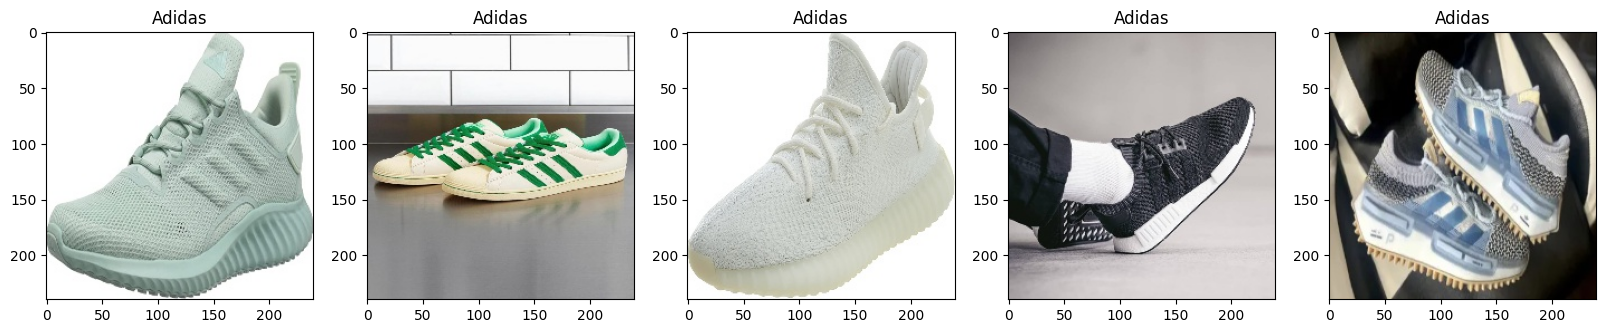

In [ ]:
# menampilkan data train dari adidas
fig,ax = plt.subplots(ncols=5,figsize=(20,5))
for i in range(5):
  cat = plt.imread(train_adidas[i])
  ax[i].imshow(cat)
  ax[i].set_title('Adidas')

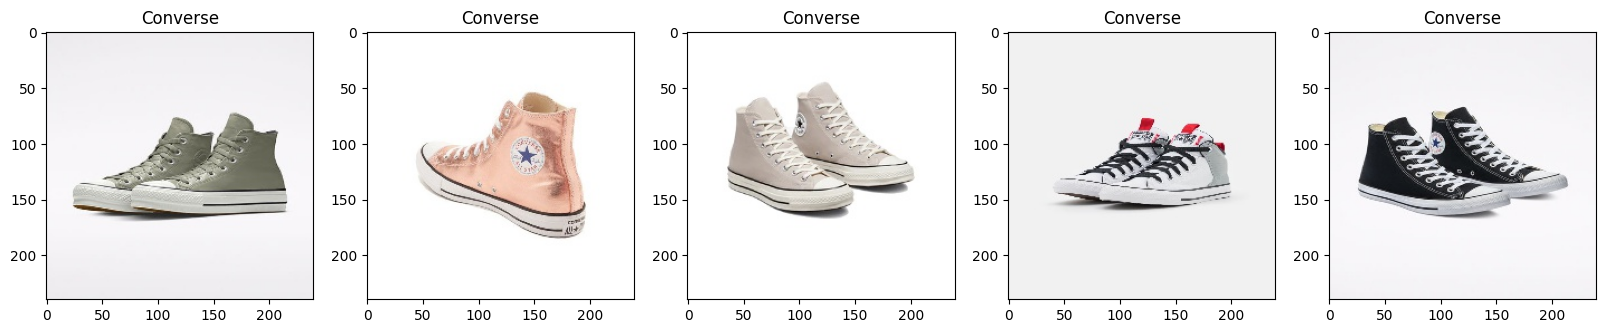

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 5))
for i in range(5):
    cat = plt.imread(train_converse[i])
    ax[i].imshow(cat)
    ax[i].set_title('Converse')

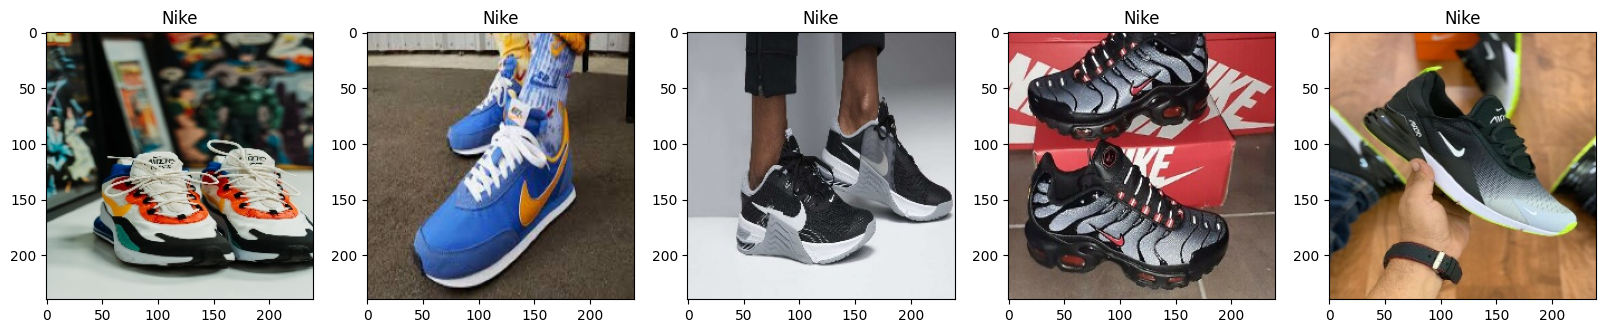

In [ ]:
# menampilkan data train dari nike
fig,ax = plt.subplots(ncols=5,figsize=(20,5))
for i in range(5):
  cat = plt.imread(train_nike[i])
  ax[i].imshow(cat)
  ax[i].set_title('Nike')

### Data Test

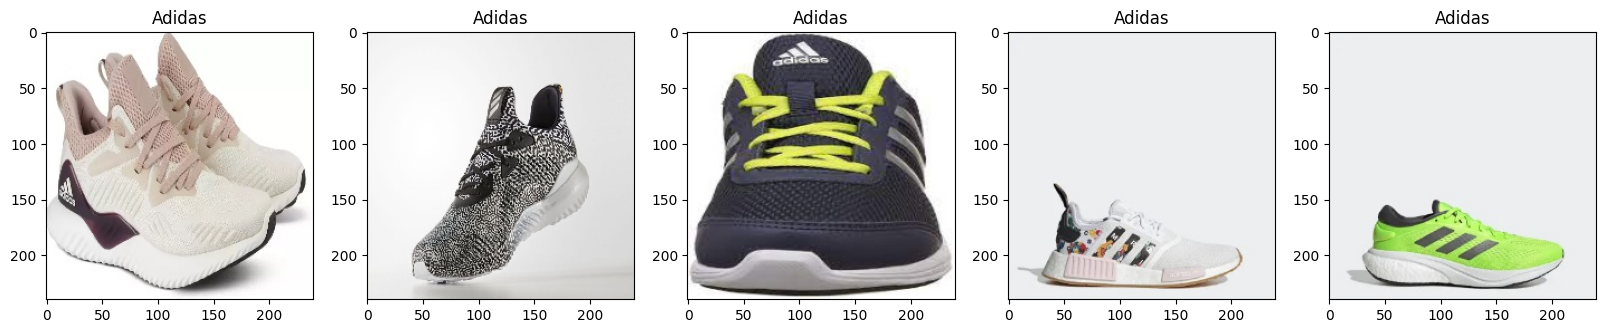

In [ ]:
fig,ax = plt.subplots(ncols=5,figsize=(20,5))
for i in range(5):
  cat = plt.imread(test_adidas[i])
  ax[i].imshow(cat)
  ax[i].set_title('Adidas')

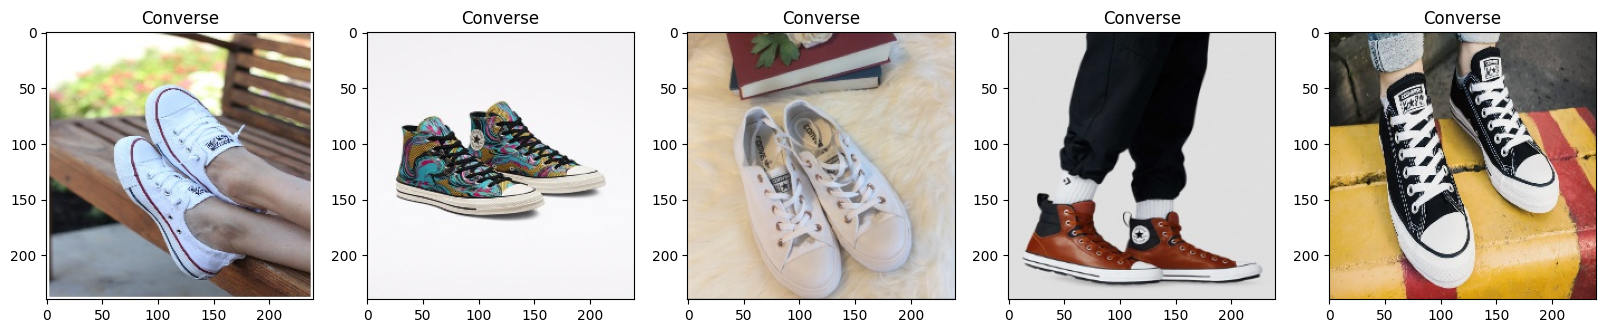

In [ ]:
fig,ax = plt.subplots(ncols=5,figsize=(20,5))
for i in range(5):
  cat = plt.imread(test_converse[i])
  ax[i].imshow(cat)
  ax[i].set_title('Converse')

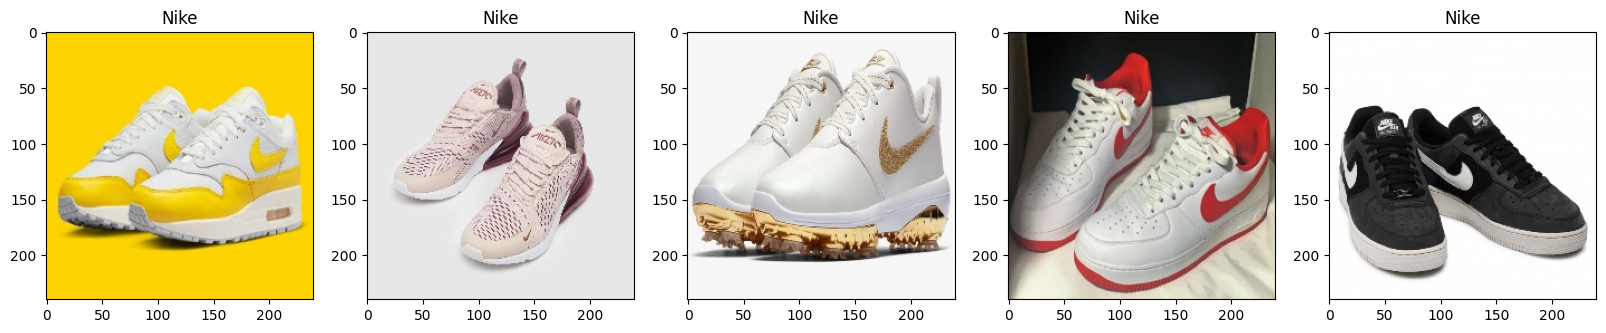

In [ ]:
fig,ax = plt.subplots(ncols=5,figsize=(20,5))
for i in range(5):
  cat = plt.imread(test_nike[i])
  ax[i].imshow(cat)
  ax[i].set_title('Nike')

Dari visualisasi sampel diatas dapat dilihat bahwa :
- Adidas rata-rata menawarkan sepatu olahraga yang fungsional dan dirancang untuk berbagai jenis aktivitas fisik. Sepatu adidas sangat populer di berbagai olahraga, termasuk sepak bola, lari, basket, dan fitness.
- Converse lebih diidentifikasi dengan sepatu kets klasik. Sepatu converse lebih cocok untuk penggunaan sehari-hari atau gaya hidup kasual daripada aktivitas olahraga.
- Nike dikenal karena sepatu olahraganya yang inovatif dan fungsional. Merek ini menawarkan berbagai sepatu yang didesain untuk berbagai olahraga, seperti lari, sepak bola, basket, tenis, golf, dan lain-lain. Nike sering menggunakan teknologi terbaru dalam desain sepatunya untuk memberikan dukungan, kenyamanan, dan performa yang optimal bagi para atlet.

## Visualisasi Plot

nike        237
converse    237
adidas      237
Name: label, dtype: int64


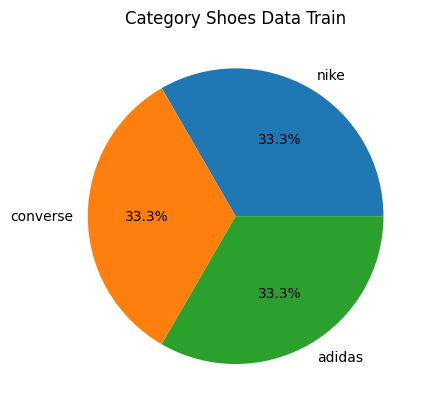

In [ ]:
# Menghitung jumlah masing-masing nilai di kolom 'label'
value_counts = train_df['label'].value_counts()
print(value_counts)

# Memplot hasil dalam bentuk diagram pie
value_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Category Shoes Data Train')
plt. ylabel("")
plt.show()

nike        38
adidas      38
converse    38
Name: label, dtype: int64


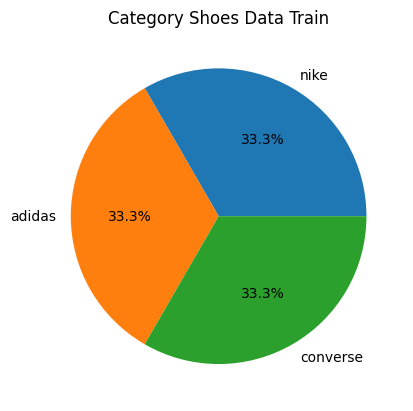

In [ ]:
# Menghitung jumlah masing-masing nilai di kolom 'label'
value_counts = test_df['label'].value_counts()
print(value_counts)

# Memplot hasil dalam bentuk diagram pie
value_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Category Shoes Data Train')
plt. ylabel("")
plt.show()

Analisis Visualisasi Plot :

Dalam dataset ini terdapat tiga kelas, diantaranya nike, adidas, dan converse.
- Train set : jumlah label yang terdapat pada masing-masing kelas sebanyak 237. Sehingga dalam data train ini data sudah balance.
- Test set : jumlah label yang terdapat pada masing-masing kelas sebanyak 38.

# Feature Engineering

> Section ini berisi proses penyiapan data untuk proses pelatihan model.

> Feature engineering yang akan saya lakukan adalah : mengambil data untuk model inference, mendefinisikan fitur dan target, split train-val-test, dan augmentasi data.

## Get Data Inference

In [ ]:
# mengambil sample data untuk inference
inf_df = train_df.sample(10, random_state=42)
inf_df

images     label
506     /content/images/train/adidas/77.jpg    adidas
394    /content/images/train/adidas/225.jpg    adidas
210   /content/images/train/converse/89.jpg  converse
247  /content/images/train/converse/179.jpg  converse
437      /content/images/train/nike/194.jpg      nike
436     /content/images/train/adidas/95.jpg    adidas
223      /content/images/train/nike/240.jpg      nike
215    /content/images/train/adidas/227.jpg    adidas
84      /content/images/train/adidas/55.jpg    adidas
439  /content/images/train/converse/113.jpg  converse

In [ ]:
# drop data train untuk inference

df_analys = train_df.drop(inf_df.index)
df_analys

images     label
0        /content/images/train/nike/121.jpg      nike
1     /content/images/train/converse/84.jpg  converse
2       /content/images/train/adidas/97.jpg    adidas
3     /content/images/train/converse/48.jpg  converse
4     /content/images/train/converse/61.jpg  converse
..                                      ...       ...
706     /content/images/train/adidas/91.jpg    adidas
707     /content/images/train/adidas/87.jpg    adidas
708  /content/images/train/converse/125.jpg  converse
709   /content/images/train/converse/77.jpg  converse
710     /content/images/train/adidas/47.jpg    adidas

[701 rows x 2 columns]

In [ ]:
# reset index

df_analys.reset_index(drop = True, inplace = True)
inf_df.reset_index(drop = True, inplace = True)

Setelah dilakukan drop, maka saya akan simpan ke dalam format csv untuk model inference.

In [ ]:
df_inf_csv = inf_df.to_csv('Inference_Fitri Octaviani.csv', index=False)
df_inf_csv

## Split Train, Val, Test

> Pada dataset ini telah dipisahkan antara data train dan test tetapi belum dipisahkan untuk data validation. Oleh karena itu, disini akan saya lakukan split untuk data validation yang diambil dari data train.

In [ ]:
# fitur
X = 'images'
# target
y = 'label'

In [ ]:
# split data train and data val
train_df, val_df = train_test_split(df_analys, train_size=0.9, random_state=23, stratify = df_analys['label'])
print('Train Size : ', train_df.shape)
print('Val Size : ', val_df.shape)
print('Test Size: ', test_df.shape)

Train Size :  (630, 2)
Val Size :  (71, 2)
Test Size:  (114, 2)


Berdasarkan informasi diatas, diketahui bahwa :
- Data train set terdiri dari 630 baris dan 2 kolom
- Data valid set terdiri dari 71 baris dan 2 kolom
- Data test set terdiri dari 114 baris dan 2 kolom

In [ ]:
# reset index
train_df.reset_index(drop = True, inplace = True)
val_df.reset_index(drop = True, inplace = True)

## Data Augmentasi

> Hal yang dilakukan pertama kali adalah menentukan ukuran panjang dan lebar untuk semua image sehingga ukuran input dan output sama. Hal ini dilakukan untuk mencegah terjadinya error saat data training.

Found 504 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


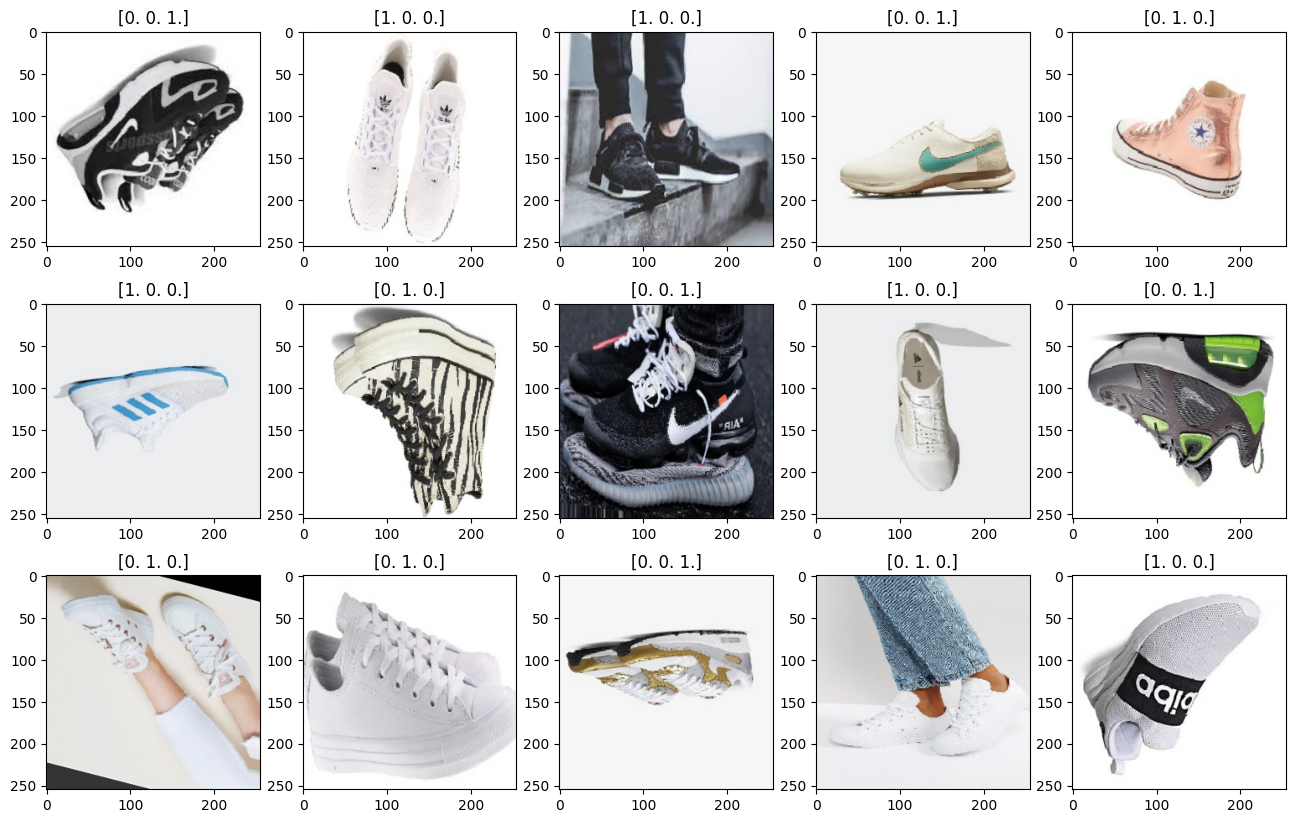

In [ ]:
# Perform augmentation only on train-set
train_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True, #pencerminan
    vertical_flip=True,
    rotation_range=15, #rotasi
    shear_range=10, #meregangkan image (bisa vertikal atau horizontal)
    validation_split=0.2)

# apply the augmentation created to the dataframe
train = train_aug.flow_from_dataframe(train_df,
                                  x_col=X,
                                  y_col=y,
                                  target_size=(255,255),
                                  class_mode='categorical',
                                  subset='training',shuffle=True)

# Get the next batch from the data generator
train_batch = train.next()

fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(16, 10))
n = 0
for i in range(3):
    for j in range(5):
        img = train_batch[0][n].astype('uint8')
        label = train_batch[1][n]
        ax[i][j].imshow(img)
        ax[i][j].set_title(label)
        n += 1
plt.show()

Found 14 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


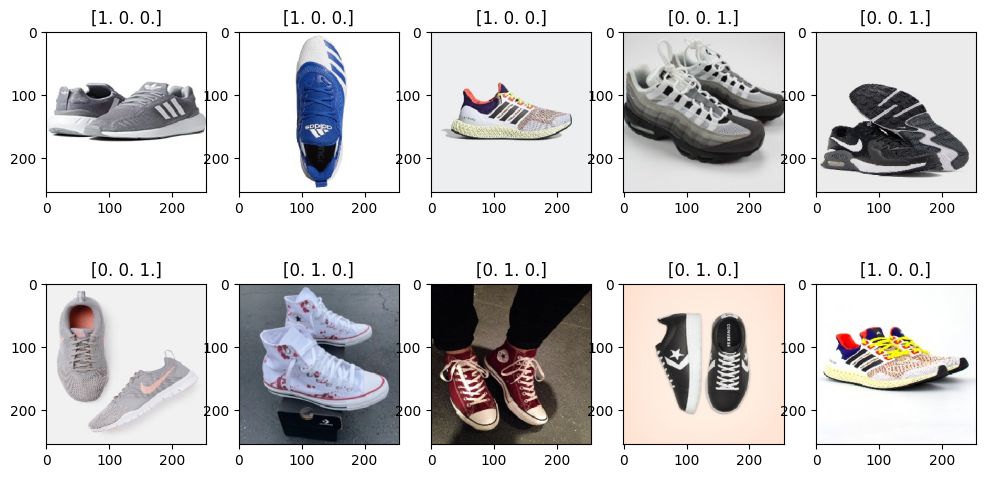

In [ ]:
# Perform augmentation only on valid-set
val_aug = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

# apply the augmentation created to the dataframe
valid = val_aug.flow_from_dataframe(val_df,
                                  x_col=X,
                                  y_col=y,
                                  target_size=(255,255),
                                  class_mode='categorical',
                                  subset='validation',shuffle=False)

# Get the next batch from the data generator
next_batch = valid.next()

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
n = 0
for i in range(2):
    for j in range(5):
        img = next_batch[0][n].astype('uint8')
        label = next_batch[1][n]
        ax[i][j].imshow(img)
        ax[i][j].set_title(label)
        n += 1
plt.show()

Found 114 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


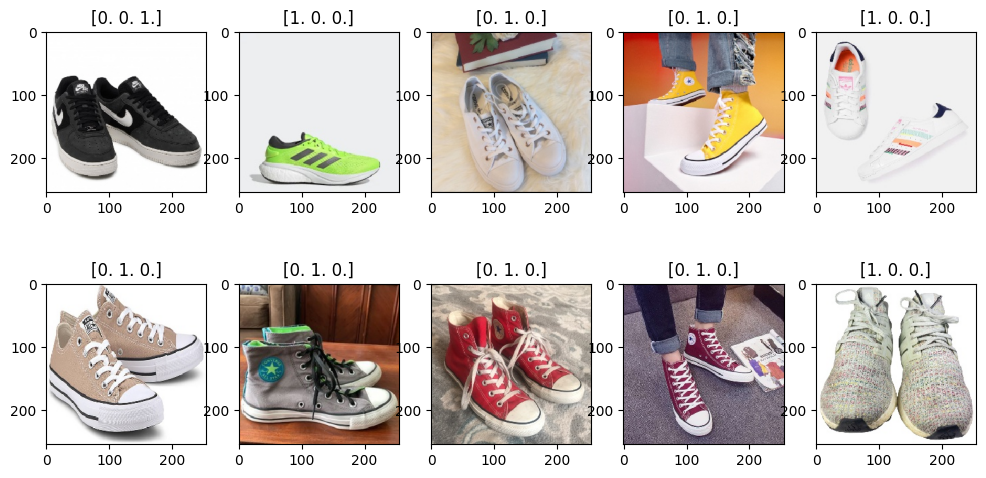

In [ ]:
# Perform augmentation only on test-set
test_aug = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

# apply the augmentation created to the dataframe
test = test_aug.flow_from_dataframe(test_df,
                                  x_col=X,
                                  y_col=y,
                                  target_size=(255,255),
                                  class_mode='categorical',
                                  shuffle=False)

# Get the next batch from the data generator
next_batch = test.next()

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
n = 0
for i in range(2):
    for j in range(5):
        img = next_batch[0][n].astype('uint8')
        label = next_batch[1][n]
        ax[i][j].imshow(img)
        ax[i][j].set_title(label)
        n += 1
plt.show()

Augmentasi merupakan suatu teknik untuk memperluas atau memperbesar data sehingga model dapat melakukan generalisasi. Hal ini dilakukan untuk mencegah adanya overfitting dan model mengenali pola yang bermacam-macam. Augmentasi yang di pakai adalah :

- horizontal_flip=True artinya membalik gambar secara horizontal
- vertical_flip=True artinya membalik gambar secara vertikal
- rotation_range=15 artinya memutar gambar dalam kisaran 15 derajat secara acak
- shear_range=10 artinya miringkan gambar dalam kisaran 10 derajat. Miringkan artinya menggeser setiap titik dalam gambar dalam arah tertentu
- validation_split=0.2 artinya menentukan bagian data latih akan digunakan sebagai data validasi untuk memonitor kinerja model selama pelatihan.

Augmentasi data hanya dilakukan pada data train, sedangkan untuk val-set dan test-set hanya dilakukan resize data karena val-set dan test-set digunakan untuk mengevaluasi model yang berarti bahwa bentuk aslinya harus utuh untuk mendapatkan kinerja yang realistis dari model kita.

In [ ]:
train.next()

(array([[[[255.      , 255.      , 255.      ],
          [255.      , 255.      , 255.      ],
          [255.      , 255.      , 255.      ],
          ...,
          [255.      , 255.      , 255.      ],
          [255.      , 255.      , 255.      ],
          [255.      , 255.      , 255.      ]],
 
         [[255.      , 255.      , 255.      ],
          [255.      , 255.      , 255.      ],
          [255.      , 255.      , 255.      ],
          ...,
          [255.      , 255.      , 255.      ],
          [255.      , 255.      , 255.      ],
          [255.      , 255.      , 255.      ]],
 
         [[255.      , 255.      , 255.      ],
          [255.      , 255.      , 255.      ],
          [255.      , 255.      , 255.      ],
          ...,
          [255.      , 255.      , 255.      ],
          [255.      , 255.      , 255.      ],
          [255.      , 255.      , 255.      ]],
 
         ...,
 
         [[255.      , 255.      , 255.      ],
          [255.   

In [ ]:
train.next()[0].shape

(32, 255, 255, 3)

Dalam dataset ini terdapat dataframe berisi 32 sampel dan setiap sampel adalah gambar yang di representasikan sebagai array 3 dimensi dengan bentuk (255, 255, 3). Dimensi terakhir 3 menunjukkan bahwa setiap piksel dalam gambar diwakili oleh 3 nilai yang sesuai dengan warna RGB. Dengan kata lain(singkatnya), dataframe berisi 32 gambar, dengan dimensi gambar 255x255 dan 3 jumlah warna (RGB).

In [ ]:
# Check the label and class of the label

train_class = train.class_indices
print('Train Set Class Label : ', train_class)

val_class = valid.class_indices
print('Val Set Class Label : ', val_class)

test_class = test.class_indices
print('Test Set Class Label : ', test_class)

Train Set Class Label :  {'adidas': 0, 'converse': 1, 'nike': 2}
Val Set Class Label :  {'adidas': 0, 'converse': 1, 'nike': 2}
Test Set Class Label :  {'adidas': 0, 'converse': 1, 'nike': 2}


Dari informasi di atas dapat dilihat bahwa terdapat 3 label, yaitu

- Untuk adidas diwakilkan dengan 0
- Untuk converse diwakilkan dengan 1
- Untuk nike diwakilkan dengan 2

# Model Definition

> Section ini mendefinisikan model.

> Saya akan mendefinisikan model CNN yang akan dibuat dengan menggunakan Sequential API. Karena dalam Sequential API dalam CNN memudahkan dalam hal pembuatan arsitektur model yang sederhana dan mudah dipahami. Dengan menggunakan sequential API, kita dapat dengan mudah menambahkan layer-layer pemrosesan yang diperlukan untuk membuat model CNN tanpa harus memikirkan bagaimana layer-layer tersebut terhubung satu sama lain. Akan tetapi dalam Sequential API ini memiliki kekurangan dalam pembuatan model arsitektur karena hanya dapat digunakan untuk membuat model sederhana sehingga akurasi tidak kompleks.

In [ ]:
# define height and width of image
img_height = 255
img_width = 255

In [ ]:
# define input size
inputs= [img_height,img_width,3]

# Create Sequential API
model_seq = Sequential()

#Layer Conv 1
model_seq.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=inputs))
model_seq.add(MaxPooling2D(pool_size= 2, strides=2))

#Layer Conv 2
model_seq.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model_seq.add(MaxPooling2D(pool_size= 2, strides=2))

# Flatten layer
model_seq.add(Flatten())
# hidden layer 1
model_seq.add(Dense(units=32, activation='relu'))
# hidden layer 2
model_seq.add(Dense(units=16, activation='relu'))
# output layer
model_seq.add(Dense(units=1,activation='sigmoid'))

# Compile
model_seq.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])


> Dalam mendefinisikan model sequential, saya memasukkan input sesuai dengan shape dari dataframe
- Convolutional layer yang saya gunakan ada 2 :
1. Convolutional layer 1 : filter yang digunakan adalah 16 dan output fitur maps akan menghasilkan ukuran 3x3. Activation function yang digunakan adalah relu
2. Convolutional layer 2 : filter yang digunakan adalah 32 dan output fitur maps akan menghasilkan ukuran 3x3. Activation function yang digunakan adalah relu
- Flatten layer digunakan untuk mengubah data atau citra yang memiliki dimensi multi-dimensi menjadi satu dimensi. Output akan dimasukkan ke hidden layer
- Hidden layer pada model digunakan sebanyak 2 layer dengan neuron sebanyak 32 dan 16 dengan activation function relu
- Output layer yang saya gunakan adalah sigmoid karena dalam dataset tersebut sudah saya ubah menjadi representasi 0, 1, 2.



> Dalam compile model dipersiapkan untuk data train. Hal yang saya lakukan adalah :
- Loss function digunakan untuk mengevaluasi seberapa baik model memprediksi data. Loss function saya gunakan adalah binary_crossentropy.
- Optimizer digunakan untuk mengoptimalkan atau menyesuaikan parameter-parameter model berdasarkan nilai loss function yang dihitung selama proses pelatihan. Optimizer yang saya gunakan adalah Adam, karena memanfaatkan keunggulan dari learning rate yang adaptif dan membantu meningkatkan efisiensi dan kinerja pelatihan model.
- Metrics digunakan untuk mengukur kinerja atau perfoema model. Metrics yang saya gunakan adalah accuracy karena saya ingin mengukur seberapa banyak sampel yang berhasil diprediksi dengan benar. Jika model melakukan prediksi dengan benar, maka hasil prediksinya akan sama dengan nilai target.


In [ ]:
# summary of model
model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 32)                3

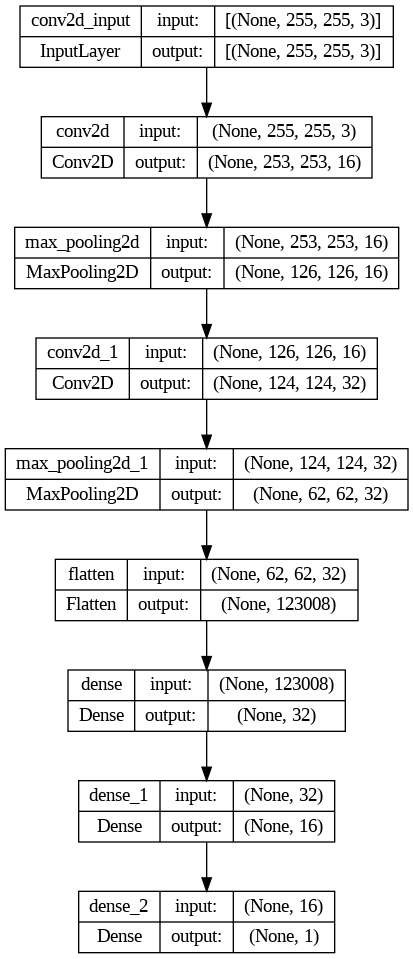

In [ ]:
# Plot Layers
tf.keras.utils.plot_model(model_seq, show_shapes=True)

## Model Training

> Section ini untuk melatih model dan hasil model.

Dalam model ini saya mendefinisikan callbacks. Callbacks adalah argumen yang memungkinkan kita untuk menentukan tindakan-tindakan tertentu selama pelatihan model. Dalam kasus ini, saya menggunakan :
- EarlyStopping untuk menghentikan proses pelatihan jika terjadi overfitting atau jika nilai val_loss tidak mengalami peningkatan dalam beberapa iterasi
- ModelCheckpoint untuk menyimpan model terbaik selama proses pelatihan berlangsung.

Dengan kombinasi kedua callbacks ini, kita dapat mengoptimalkan pelatihan model dengan lebih baik dan meningkatkan kualitas hasil akhir model.

In [ ]:
# define callback
callback= [
    EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True), # stop the training if no improvement after n times
    ModelCheckpoint('best_model.h5', monitor='accuracy', save_best_only=True), # save the best model after this callback is executed
]

In [ ]:
# training model with 50 epochs
history = model_seq.fit(train,
                    epochs=50,
                    validation_data=valid,
                    batch_size= 32,
                    callbacks= callback
                    )

Epoch 1/50
16/16 [==============================] - 13s 537ms/step - loss: 129.1270 - accuracy: 0.5225 - val_loss: 2.3445 - val_accuracy: 0.6667
Epoch 2/50
16/16 [==============================] - 7s 444ms/step - loss: 1.5693 - accuracy: 0.5615 - val_loss: 0.7403 - val_accuracy: 0.6190
Epoch 3/50
16/16 [==============================] - 8s 529ms/step - loss: 0.8881 - accuracy: 0.5979 - val_loss: 0.7019 - val_accuracy: 0.5952
Epoch 4/50
16/16 [==============================] - 7s 460ms/step - loss: 0.7591 - accuracy: 0.5800 - val_loss: 0.7025 - val_accuracy: 0.5952
Epoch 5/50
16/16 [==============================] - 8s 493ms/step - loss: 0.7193 - accuracy: 0.6190 - val_loss: 0.6792 - val_accuracy: 0.6190
Epoch 6/50
16/16 [==============================] - 9s 548ms/step - loss: 0.6902 - accuracy: 0.6177 - val_loss: 0.6732 - val_accuracy: 0.6429
Epoch 7/50
16/16 [==============================] - 9s 543ms/step - loss: 0.6829 - accuracy: 0.6303 - val_loss: 0.6735 - val_accuracy: 0.6429
Epo

In [ ]:
# change to dataframe
metrics_model = pd.DataFrame(history.history)
metrics_model

loss  accuracy  val_loss  val_accuracy
0   129.127014  0.522487  2.344494      0.666667
1     1.569277  0.561508  0.740323      0.619048
2     0.888110  0.597884  0.701911      0.595238
3     0.759057  0.580026  0.702484      0.595238
4     0.719298  0.619048  0.679243      0.619048
5     0.690162  0.617725  0.673218      0.642857
6     0.682927  0.630291  0.673468      0.642857
7     0.679917  0.638228  0.669636      0.642857
8     0.673598  0.640873  0.668503      0.642857
9     0.668419  0.646825  0.667326      0.666667
10    0.663862  0.655423  0.665736      0.666667
11    0.662511  0.653439  0.660865      0.666667
12    0.661345  0.655423  0.658211      0.666667
13    0.659104  0.659392  0.655846      0.666667
14    0.654346  0.662698  0.654086      0.666667
15    0.656767  0.661376  0.651771      0.666667
16    0.648458  0.662698  0.649580      0.666667
17    0.646165  0.665344  0.647496      0.666667
18    0.646780  0.664021  0.645644      0.666667
19    0.643337  0.664021  0.643825      0.666667
20    0.641868  0.666005  0.642547      0.666667
21    0.640908  0.665344  0.641093      0.666667
22    0.640464  0.664021  0.640004      0.666667
23    0.639800  0.664683  0.639203      0.666667
24    0.639451  0.666005  0.638805      0.666667
25    0.640286  0.664683  0.638441      0.666667

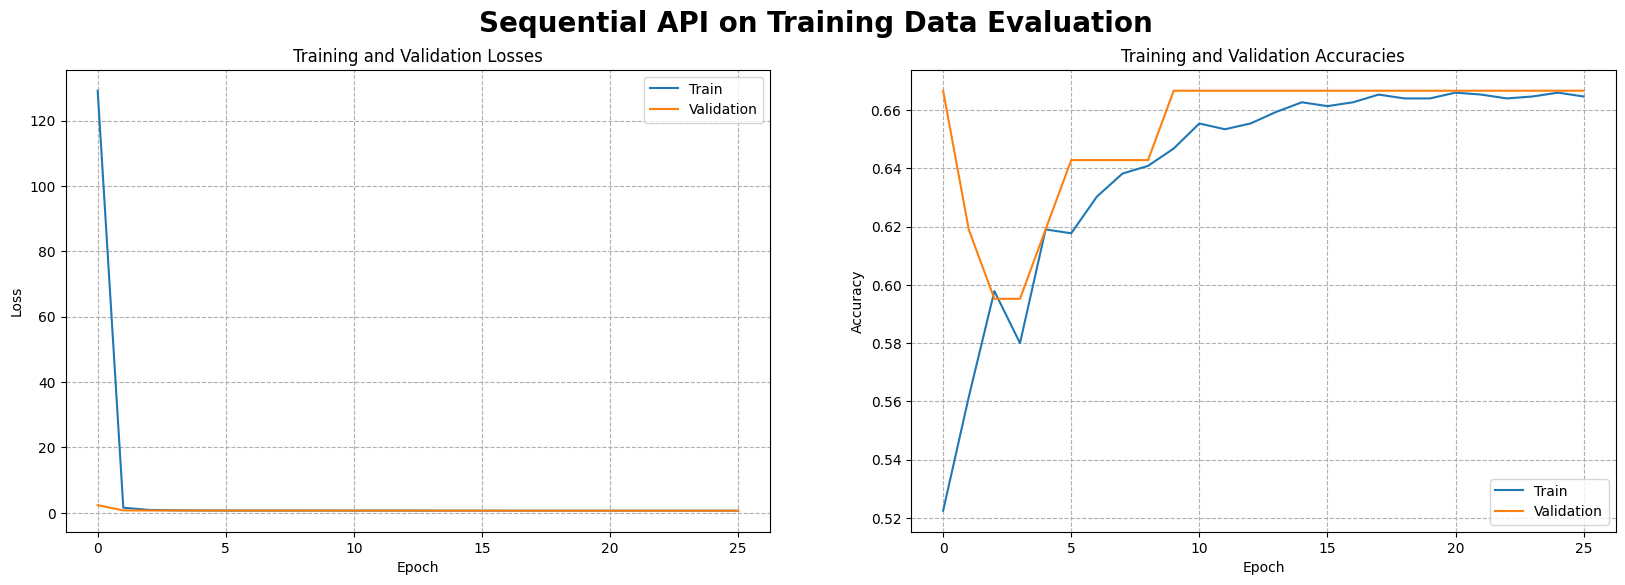

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Sequential API on Training Data Evaluation', fontsize=20, weight='bold')

plt.subplot(1, 2, 1)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(linestyle='--')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.title("Training and Validation Accuracies", fontsize=12)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(linestyle='--')

plt.show()

In [ ]:
train_loss, train_acc = model_seq.evaluate(train)

print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_acc:.4f}')

16/16 [==============================] - 9s 546ms/step - loss: 0.6425 - accuracy: 0.6660
Train loss: 0.6425
Train accuracy: 0.6660


In [ ]:
val_loss, val_acc = model_seq.evaluate(valid)

print(f'Val loss: {val_loss:.4f}')
print(f'Val accuracy: {val_acc:.4f}')

1/1 [==============================] - 0s 63ms/step - loss: 0.6425 - accuracy: 0.6667
Val loss: 0.6425
Val accuracy: 0.6667


In [ ]:
test_loss, test_acc = model_seq.evaluate(test)

print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

4/4 [==============================] - 0s 115ms/step - loss: 0.6437 - accuracy: 0.6667
Test loss: 0.6437
Test accuracy: 0.6667


- Karena data balance maka nilai metrics yang saya gunakan adalah akurasi. Terlihat bahwa nilai akurasi pada data train, data val, dan data test adalah 66%. Ini menunjukkan bahwa model memiliki akurasi yang relatif konsisten di semua dataset tersebut. Dalam kesimpulannya, model dengan nilai akurasi yang serupa pada data train, data val, dan data test adalah indikasi bahwa model tersebut memiliki goodfit atau kinerja yang baik dalam memprediksi data secara umum. Akan tetapi akurasi yang didapatkan hanya mencapai 66% sehingga model masih buruk dalam melakukan klasifikasi secara benar.

# Prediction (inference)

> Dalam section ini saya ini mencoba memprediksi kelas berdasarkan model sequential.

In [ ]:
# prediksi
def prediction(file):
  img = tf.keras.utils.load_img(file, target_size=(255, 255))


  plt.imshow(img)#astype('uint8'))
  x = tf.keras.utils.img_to_array(img)/255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_seq.predict(images, batch_size=10)
  idx = np.argmax(classes)
  clas = ['adidas','converse','nike']
  print('Prediction is a {}'.format(clas[idx]))

1/1 [==============================] - 0s 164ms/step
Prediction is a adidas


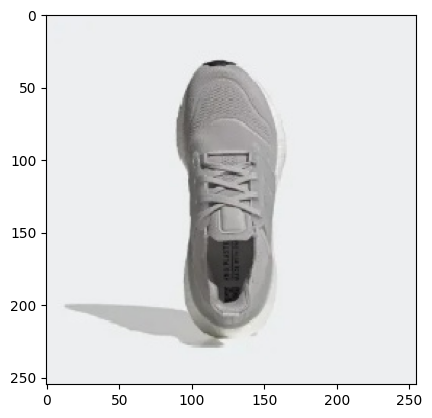

In [ ]:
prediction('/content/images/test/adidas/11.jpg')

# Model Improvement

Karena model sebelumnya masih mengalami accuracy yang kurang baik, maka untuk model improvement saya menggunakan transfer learning, dimana pretrained model yang saya gunakan adalah VGG16. Alasannya karena VGG16 memiliki kemampuan sebagai ekstraktor fitur yang kuat, telah terlatih pada dataset besar (ImageNet), dan tersedia dengan dukungan yang luas sehingga dapat menghemat waktu dan sumber daya dalam mengatasi tugas computer vision dengan hasil yang baik.

In [ ]:
# clears running sessions on Keras
tf.keras.backend.clear_session()

Langkah awal yang saya lakukan adalah clear_session agar membersihkan sesi komputasi dari TensorFlow dan memulihkan penggunaan memori.

Setelah itu adalah mendownload model VGG16 yang menggunakan weight imagenet.


In [ ]:
# Load pretrained model
base_model = VGG16(include_top = False, weights = "imagenet" ,input_shape=inputs)
base_model.trainable = False

In [ ]:
base_model = Sequential([base_model,
                         GlobalAveragePooling2D(),
                         Dense(512, activation = 'relu'),
                         BatchNormalization(),
                         Dropout(0.3),
                         Dense(1024, activation = 'relu'),
                         Dropout(0.15),
                         Dense(2048, activation = 'relu'),
                         Dropout(0.3),
                         Dense(3, activation = 'softmax')
                         ])

- Dalam model improvement, saya membentuk sebuah sequential model yang mana VGG16 dijadikan sebagai layer pertama dalam model
- GlobalAveragePooling2D() untuk mengubah output dari VGG16 menjadi vektor 1D
- Dense(512, activation = 'relu') sebagai hidden layer yang memproses fitur-fitur hasil dari VGG16
- BatchNormalization() untuk meningkatkan stabilitas model
- Dropout()
- Dense(3, activation = 'softmax') Lapisan fully connected terakhir dengan 3 unit neuron (asumsi memiliki 3 kelas pada tugas klasifikasi). Fungsi aktivasi yang digunakan adalah softmax untuk menghasilkan probabilitas prediksi untuk setiap kelas.

In [ ]:
# model summary
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              5

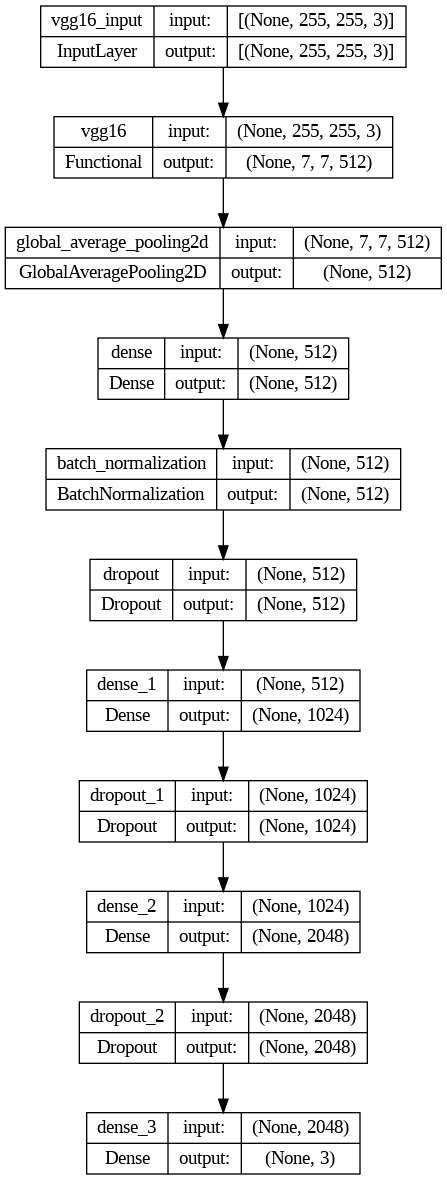

In [ ]:
# Plot Layers
tf.keras.utils.plot_model(base_model, show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the model
base_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Model kemudian akan di compile dengan menggunakan Adam optimizer lalu dilatih dengan menggunakan epoch 50.

In [ ]:
# Train the model
history_vgg = base_model.fit(train,
                      epochs=50,
                      validation_data=valid,
                      batch_size= 32,
                      callbacks= callback,
                      verbose=1)

Epoch 1/50
16/16 [==============================] - 25s 1s/step - loss: 1.1130 - accuracy: 0.4325 - val_loss: 1.2695 - val_accuracy: 0.4286
Epoch 2/50
16/16 [==============================] - 9s 561ms/step - loss: 0.9083 - accuracy: 0.6012 - val_loss: 1.5557 - val_accuracy: 0.4286
Epoch 3/50
16/16 [==============================] - 9s 514ms/step - loss: 0.7899 - accuracy: 0.6746 - val_loss: 1.0068 - val_accuracy: 0.5000
Epoch 4/50
16/16 [==============================] - 10s 597ms/step - loss: 0.7102 - accuracy: 0.7063 - val_loss: 0.8983 - val_accuracy: 0.5714
Epoch 5/50
16/16 [==============================] - 10s 612ms/step - loss: 0.6395 - accuracy: 0.7361 - val_loss: 0.9113 - val_accuracy: 0.6429
Epoch 6/50
16/16 [==============================] - 9s 557ms/step - loss: 0.5986 - accuracy: 0.7579 - val_loss: 1.0111 - val_accuracy: 0.6429
Epoch 7/50
16/16 [==============================] - 10s 591ms/step - loss: 0.5692 - accuracy: 0.7679 - val_loss: 0.7407 - val_accuracy: 0.7143
Epoch

In [ ]:
# change to dataframe
metrics_vgg = pd.DataFrame(history_vgg.history)
metrics_vgg

loss  accuracy  val_loss  val_accuracy
0   1.112957  0.432540  1.269458      0.428571
1   0.908331  0.601190  1.555713      0.428571
2   0.789935  0.674603  1.006774      0.500000
3   0.710232  0.706349  0.898261      0.571429
4   0.639547  0.736111  0.911336      0.642857
5   0.598629  0.757937  1.011055      0.642857
6   0.569248  0.767857  0.740732      0.714286
7   0.497645  0.825397  0.698032      0.714286
8   0.466043  0.819444  0.691748      0.785714
9   0.433646  0.817460  0.605840      0.857143
10  0.443002  0.821429  0.665900      0.857143
11  0.398086  0.849206  0.674588      0.857143
12  0.341512  0.884921  0.588725      0.857143
13  0.355644  0.865079  0.696342      0.857143
14  0.369468  0.849206  0.699484      0.857143
15  0.308616  0.888889  0.667229      0.857143
16  0.301088  0.882937  0.701353      0.857143
17  0.343886  0.869048  0.686221      0.857143
18  0.295661  0.884921  0.714781      0.785714
19  0.255058  0.894841  0.808363      0.857143
20  0.281222  0.890873  0.804546      0.857143
21  0.239935  0.910714  0.737976      0.857143
22  0.316454  0.886905  0.877639      0.857143
23  0.278099  0.888889  0.714401      0.857143
24  0.195969  0.918651  0.816434      0.857143
25  0.189606  0.944444  0.786626      0.857143
26  0.212420  0.910714  0.763006      0.857143
27  0.236996  0.906746  0.751693      0.857143
28  0.176244  0.926587  0.929843      0.857143
29  0.208839  0.908730  0.798876      0.857143
30  0.200976  0.918651  0.963856      0.857143

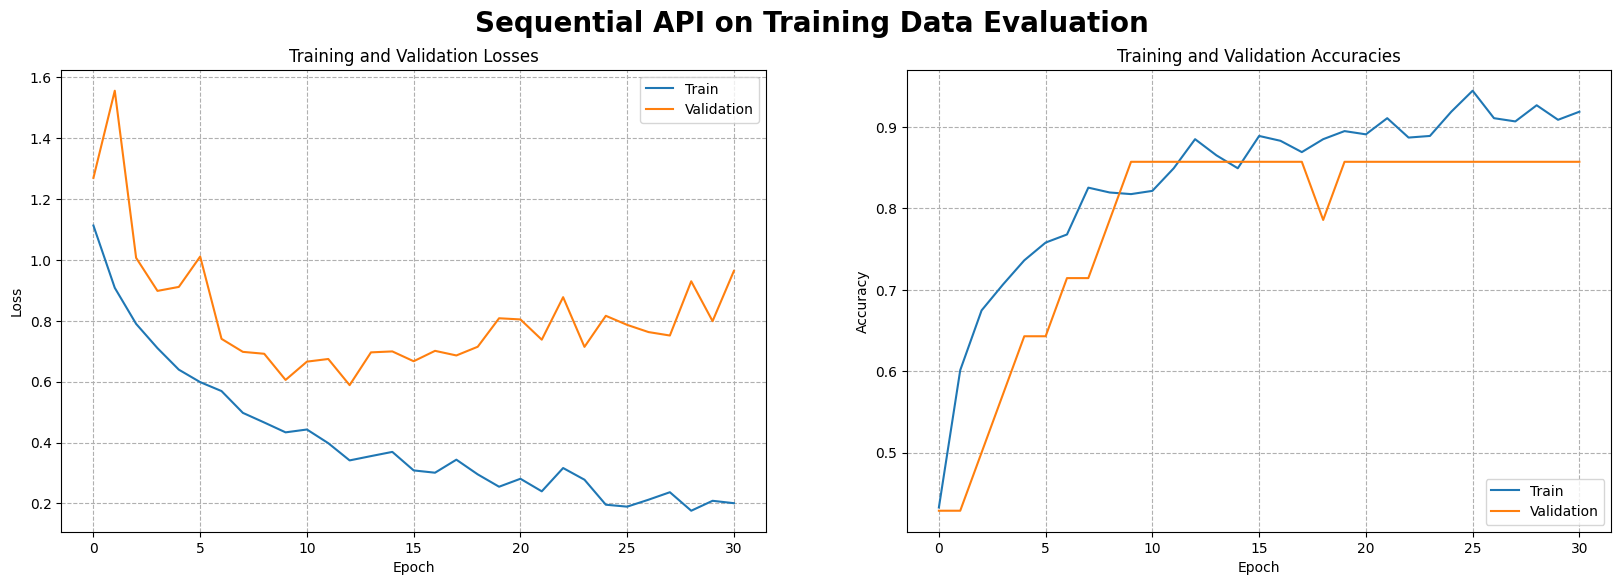

In [ ]:

# Plot training & validation loss values
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Sequential API on Training Data Evaluation', fontsize=20, weight='bold')

plt.subplot(1, 2, 1)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(linestyle='--')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.title("Training and Validation Accuracies", fontsize=12)
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(linestyle='--')

plt.show()


In [ ]:
train_loss, train_acc = base_model.evaluate(train)

print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_acc:.4f}')

16/16 [==============================] - 9s 533ms/step - loss: 0.1070 - accuracy: 0.9722
Train loss: 0.1070
Train accuracy: 0.9722


In [ ]:
val_loss, val_acc = base_model.evaluate(valid)

print(f'Val loss: {val_loss:.4f}')
print(f'Val accuracy: {val_acc:.4f}')

1/1 [==============================] - 0s 122ms/step - loss: 0.7866 - accuracy: 0.8571
Val loss: 0.7866
Val accuracy: 0.8571


In [ ]:
test_loss, test_acc = base_model.evaluate(test)

print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

4/4 [==============================] - 4s 1s/step - loss: 0.5984 - accuracy: 0.7982
Test loss: 0.5984
Test accuracy: 0.7982


In [ ]:
# define labels
num_label = train.class_indices

# label from test-set
y_test = test_df['label'].copy().map(num_label).astype('int')

4/4 [==============================] - 1s 147ms/step
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        38
           1       0.81      0.89      0.85        38
           2       0.77      0.71      0.74        38

    accuracy                           0.79       114
   macro avg       0.79      0.79      0.79       114
weighted avg       0.79      0.79      0.79       114



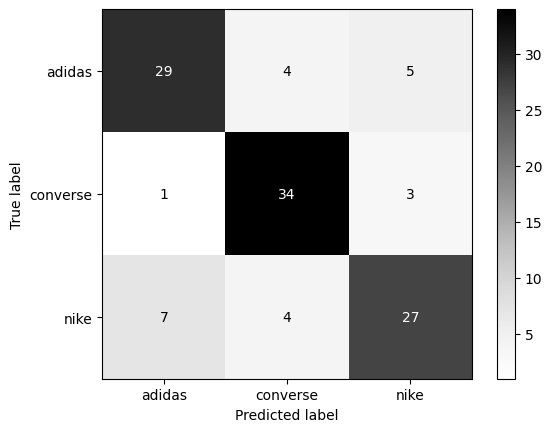

In [ ]:
# Assuming y_pred_func is generated as follows, using model.predict:
y_pred_func = base_model.predict(test)
y_pred_func = np.where(y_pred_func >= 0.5, 1, 0)

# Convert y_pred_func to single-dimensional array of integer labels
y_pred_func = np.argmax(y_pred_func, axis=1)

# Print classification report and plot confusion matrix
print(classification_report(y_test, y_pred_func))

cm = confusion_matrix(y_test, y_pred_func)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['adidas', 'converse', 'nike'])
disp.plot(cmap='Greys')
plt.show()


> Berdasarkan hasil evaluasi model improvement ini terlihat bahwa nilai akurasinya jauh lebih besar dari model pertama. Nilai akurasi pada train adalah 97% dan test 79%. Hal ini menunjukkan bahwa model masih tergolong overfitting, dikarenakan saya tidak menghandling k-fold cross validation

> Threshold yang saya gunakan adalah 0.5 karena untuk menghindari bias antar label kelas.

> Dalam confusion matrix pada test menunjukkan bahwa :
- 29 label adidas benar diprediksi sebagai adidas
- 4 label adidas salah diprediksi sebagai converse
- 5 label adidas salah diprediksi sebagai nike
- 1 label converse salah diprediksi sebagai adidas
- 34 label converse benar diprediksi sebagai converse
- 3 label converse salah diprediksi sebagai nike
- 7 label nike salah diprediksi sebagai adidas
- 4 label nike salah diprediksi sebagai nike
- 27 label nike benar diprediksi sebagai nike

# Inference

> Pada section ini saya ingin memprediksi kelas pada model transfer learning

In [ ]:
def prediction(file):
  img = tf.keras.utils.load_img(file, target_size=(255, 255))
  x = tf.keras.utils.img_to_array(img)

  plt.imshow(x.astype('uint8'))

  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = base_model.predict(images, batch_size=10)
  idx = np.argmax(classes)
  clas = ['adidas','converse','nike']
  print('Prediction is a {}'.format(clas[idx]))

1/1 [==============================] - 1s 633ms/step
Prediction is a converse


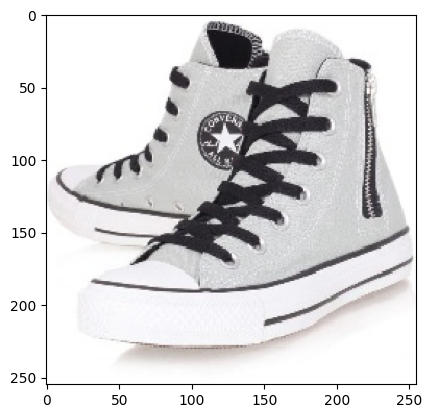

In [ ]:
prediction('/content/images/test/converse/12.jpg')

1/1 [==============================] - 0s 25ms/step
Prediction is a nike


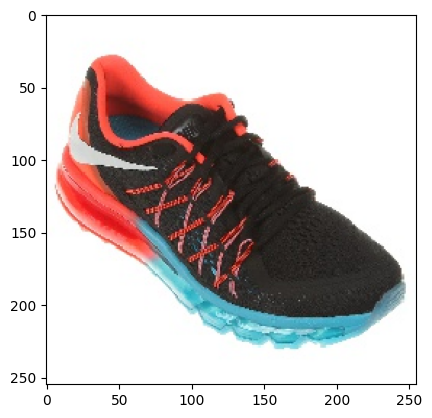

In [ ]:
prediction('/content/images/train/nike/103.jpg')

1/1 [==============================] - 0s 27ms/step
Prediction is a adidas


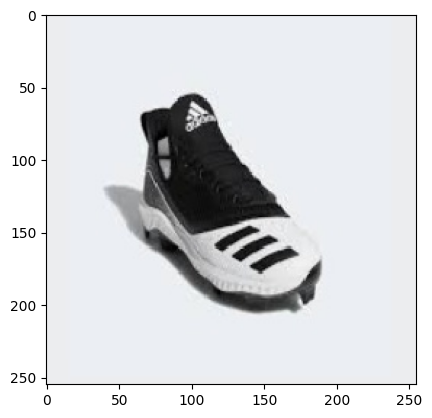

In [ ]:
prediction('/content/images/test/adidas/9.jpg')

# Model Saving

> Pada section ini dilakukan proses penyimpanan model terbaik berdasarkan hasil evaluasi sebelumnya.

In [ ]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              5

In [ ]:
# Freeze Model

base_model.trainable = False
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              5

In [ ]:
# Save Model
base_model.save('model_vgg.h5')

# Conclusion

> Pada section ini berisi kesimpulan.

> Dalam tugas ini dibuat model computer vision dalam CNN untuk melakukan klasifikasi gambar. Dataset yang digunakan adalah adidas, converse, dan nike yang telah terpisah antara direktori train dan test dengan ekstensi gambar .jpg

> Exploratory Data Analysis
- Dari proses EDA dapat diketahui bahwa terdapat 3 kelas diantaranya adids, converse, dan nike yang masing masing kelasnya sudah balance
- Dalam train jumlah entri sebanyak 711 label, yang mana masing-masing kelas memiliki 237 label
- Dalam test jumlah entri sebanyak 114 label, yang mana masing-masing kelas memiliki 37 label

> Sample Image
- Dari visualisasi sample image dapat dilihat bahwa adidas dan nike lebih fokus pada sepatu olahraga dan atletik, sementara converse lebih cocok untuk penggunaan sehari-hari dan gaya hidup kasual.

> Model
- Dalam model saya menggunakan sequential dan VGG16
- Berdasarkan hasil training model sequential, metrik yang saya gunakan adalah accuracy karena data merupakan balance dan saya ingin mengukur seberapa banyak sampel yang berhasil diprediksi dengan benar. Jika model melakukan prediksi dengan benar, maka hasil prediksinya akan sama dengan nilai target. Akan tetapi setelah saya evaluasi model sequential accuracy yang didapatkan pada test hanya mencapai 66% sehingga model masih perlu dikembangkan lebih lanjut.
- Model improvement yang saya gunakan adalah VGG16. Berdasarkan hasil training model improvement nilai akurasinya jauh lebih besar dibandingkan model sequential. Nilai akurasi pada train adalah 97% sedangkan pada test 79%. Hal ini menunjukkan bahwa model tersebut masih overfitting sehingga perlu ditindaklanjuti menggunakan k-fold cross validation.

> Inference
- Dalam percobaan inference dapat mengetahui keakuratan model dalam mengklasifikasi gambar adidas, converse, dan nike. Dapat terlihat bahwa tidak ada perbedaan antara hasil prediksi dengan data aktual. Sehingga model ini sudah cukup bagus untuk mengklasifikasi gambar adidas, converse, dan nike.

> Overall Business
- Nike dan Adidas memang telah membangun citra sebagai merek yang terkait erat dengan olahraga dan atletik. Sehingga dalam strategi pemasaran dapat bekerja sama dengan atlet profesional dan tim olahraga untuk mempromosikan produk. Selain olahraga, juga dapat menargetkan segmen pasar gaya hidup dan fashion untuk menciptakan lini produk yang lebih berorientasi pada gaya hidup aktif dan santai
> Converse dikenal sebagai merek sepatu kets klasik dan telah menjadi ikon gaya kasual. Sehingga dalam strategi pemasaran bisa berfokus pada aspek budaya populer seperti musik, seni, dan gaya hidup anak muda. Selain itu juga dapat bekerja sama dengan artis terkenal serta berpartisipasi dalam acara dan festival untuk memperkuat citra sebagai merek yang relevan dengan budaya anak muda.